# Import Libraries

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [10]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomResizedCrop(28),                                    
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomAffine( degrees =0,translate=(0.1,0.1), scale=(0.9, 1.1),shear=(-10, 10, 20, 40)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [13]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value)
        ) # output_size = 26 
        #o/p size=16*26*26 RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 24 
        #o/p size=32*24*24 RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        #o/p size=10*24*24 RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
         #o/p size=10*12*12 RF=6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 10
        #o/p size =16*10*10 RF=10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 8
        #o/p size = 16*8*8 RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        #o/p size = 16*6*6 RF = 18
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        #o/p size = 16*6*6 RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        #o/p size = 16*1*1 RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 
        #o/p size = 10*1*1 RF = 32


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 8, 24, 24]             128
         MaxPool2d-6            [-1, 8, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           1,152
              ReLU-8           [-1, 16, 10, 10]               0
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,304
             ReLU-11             [-1, 16, 8, 8]               0
      BatchNorm2d-12             [-1, 16, 8, 8]              32
           Conv2d-13             [-1, 16, 6, 6]           2,304
             ReLU-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg = 1e-6
    l1_loss = torch.tensor(0., requires_grad=True)
    l1_loss=l1_loss.to(device)
    l2_loss = torch.zeros(1)
    l2_loss=l2_loss.to(device)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l1_loss = l1_loss + reg*(torch.norm(param, 1))
            l2_loss = l2_loss + ( reg * (torch.norm(param, 2)))
    loss=loss+l1_loss+l2_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [20]:
x=torch.tensor([1.0,2.0,3.0])
print(torch.norm(x,2))

tensor(3.7417)


In [17]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1011912003159523 Batch_id=468 Accuracy=92.08: 100%|███████████████████████████| 469/469 [00:55<00:00,  8.70it/s]



Test set: Average loss: 0.0711, Accuracy: 9794/10000 (97.94%)

EPOCH: 1


Loss=0.017318211495876312 Batch_id=468 Accuracy=97.91: 100%|█████████████████████████| 469/469 [00:55<00:00,  8.60it/s]



Test set: Average loss: 0.0527, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.0783730000257492 Batch_id=468 Accuracy=98.46: 100%|███████████████████████████| 469/469 [00:55<00:00, 12.93it/s]



Test set: Average loss: 0.0340, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.09544043987989426 Batch_id=468 Accuracy=98.54: 100%|██████████████████████████| 469/469 [00:55<00:00,  8.56it/s]



Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.035589855164289474 Batch_id=468 Accuracy=98.79: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.77it/s]



Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.03803614526987076 Batch_id=468 Accuracy=98.85: 100%|██████████████████████████| 469/469 [00:55<00:00,  8.25it/s]



Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.050233665853738785 Batch_id=468 Accuracy=98.94: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.53it/s]



Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.026646938174962997 Batch_id=468 Accuracy=98.96: 100%|█████████████████████████| 469/469 [00:55<00:00,  8.48it/s]



Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.012861743569374084 Batch_id=468 Accuracy=99.07: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.57it/s]



Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.01647760532796383 Batch_id=468 Accuracy=99.15: 100%|██████████████████████████| 469/469 [00:56<00:00,  8.34it/s]



Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.03763847053050995 Batch_id=468 Accuracy=99.08: 100%|██████████████████████████| 469/469 [00:55<00:00,  8.36it/s]



Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.004747034516185522 Batch_id=468 Accuracy=99.17: 100%|█████████████████████████| 469/469 [00:54<00:00,  9.13it/s]



Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.024122973904013634 Batch_id=468 Accuracy=99.15: 100%|█████████████████████████| 469/469 [00:55<00:00,  8.66it/s]



Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.04086011275649071 Batch_id=468 Accuracy=99.24: 100%|██████████████████████████| 469/469 [00:54<00:00,  8.69it/s]



Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.054676078259944916 Batch_id=468 Accuracy=99.26: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.57it/s]



Test set: Average loss: 0.0204, Accuracy: 9948/10000 (99.48%)

EPOCH: 15


Loss=0.045692846179008484 Batch_id=468 Accuracy=99.25: 100%|█████████████████████████| 469/469 [00:56<00:00, 13.01it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.015245254151523113 Batch_id=468 Accuracy=99.26: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.92it/s]



Test set: Average loss: 0.0187, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.08730559051036835 Batch_id=468 Accuracy=99.30: 100%|██████████████████████████| 469/469 [00:54<00:00,  8.61it/s]



Test set: Average loss: 0.0192, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.0069778370670974255 Batch_id=468 Accuracy=99.35: 100%|████████████████████████| 469/469 [00:54<00:00,  8.93it/s]



Test set: Average loss: 0.0186, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.02201789617538452 Batch_id=468 Accuracy=99.42: 100%|██████████████████████████| 469/469 [00:53<00:00,  9.02it/s]



Test set: Average loss: 0.0161, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.016360390931367874 Batch_id=468 Accuracy=99.35: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.62it/s]



Test set: Average loss: 0.0190, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.037075188010931015 Batch_id=468 Accuracy=99.41: 100%|█████████████████████████| 469/469 [00:54<00:00,  8.60it/s]



Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.09118056297302246 Batch_id=468 Accuracy=99.40: 100%|██████████████████████████| 469/469 [00:52<00:00, 10.47it/s]



Test set: Average loss: 0.0154, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Loss=0.022526012733578682 Batch_id=468 Accuracy=99.42: 100%|█████████████████████████| 469/469 [00:52<00:00,  9.01it/s]



Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.013699871487915516 Batch_id=468 Accuracy=99.47: 100%|█████████████████████████| 469/469 [00:42<00:00, 11.01it/s]



Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.01783769205212593 Batch_id=468 Accuracy=99.39: 100%|██████████████████████████| 469/469 [00:27<00:00, 16.78it/s]



Test set: Average loss: 0.0159, Accuracy: 9944/10000 (99.44%)

EPOCH: 26


Loss=0.00321300164796412 Batch_id=468 Accuracy=99.44: 100%|██████████████████████████| 469/469 [00:31<00:00, 14.93it/s]



Test set: Average loss: 0.0151, Accuracy: 9950/10000 (99.50%)

EPOCH: 27


Loss=0.019024644047021866 Batch_id=468 Accuracy=99.44: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.14it/s]



Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.02823493629693985 Batch_id=468 Accuracy=99.42: 100%|██████████████████████████| 469/469 [00:23<00:00, 19.69it/s]



Test set: Average loss: 0.0154, Accuracy: 9950/10000 (99.50%)

EPOCH: 29


Loss=0.005556149408221245 Batch_id=468 Accuracy=99.45: 100%|█████████████████████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


Loss=0.02042599581182003 Batch_id=468 Accuracy=99.46: 100%|██████████████████████████| 469/469 [00:22<00:00, 23.17it/s]



Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 31


Loss=0.009891526773571968 Batch_id=468 Accuracy=99.50: 100%|█████████████████████████| 469/469 [00:22<00:00, 22.48it/s]



Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99.45%)

EPOCH: 32


Loss=0.018818363547325134 Batch_id=468 Accuracy=99.48: 100%|█████████████████████████| 469/469 [00:22<00:00, 24.16it/s]



Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.06345680356025696 Batch_id=468 Accuracy=99.49: 100%|██████████████████████████| 469/469 [00:22<00:00, 23.09it/s]



Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 34


Loss=0.005207114387303591 Batch_id=468 Accuracy=99.47: 100%|█████████████████████████| 469/469 [00:22<00:00, 23.89it/s]



Test set: Average loss: 0.0176, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.012450913898646832 Batch_id=468 Accuracy=99.48: 100%|█████████████████████████| 469/469 [00:21<00:00, 23.60it/s]



Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

EPOCH: 36


Loss=0.009407217614352703 Batch_id=468 Accuracy=99.58: 100%|█████████████████████████| 469/469 [00:21<00:00, 23.40it/s]



Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.037317924201488495 Batch_id=468 Accuracy=99.52: 100%|█████████████████████████| 469/469 [00:22<00:00, 23.64it/s]



Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.008513313718140125 Batch_id=468 Accuracy=99.55: 100%|█████████████████████████| 469/469 [00:22<00:00, 24.16it/s]



Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.07562468200922012 Batch_id=468 Accuracy=99.53: 100%|██████████████████████████| 469/469 [00:22<00:00, 24.10it/s]



Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

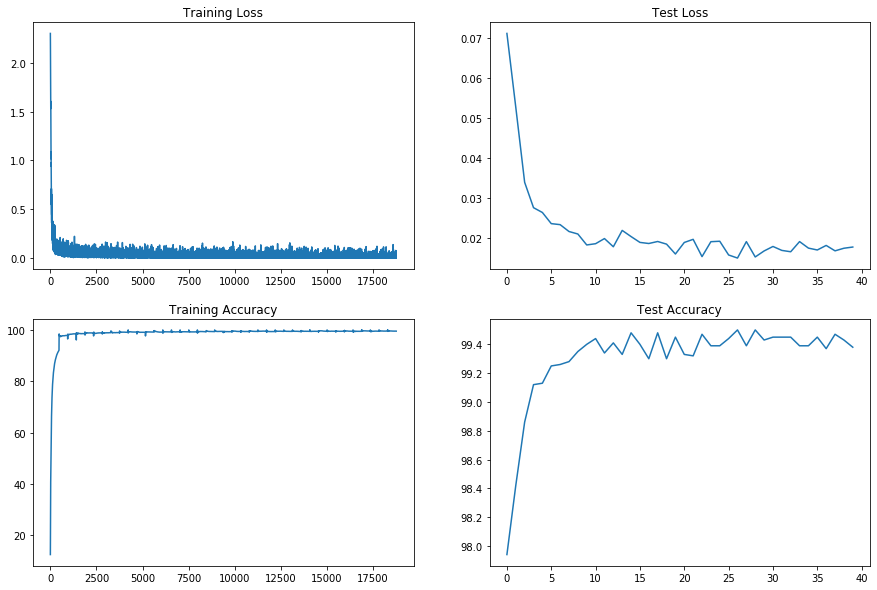

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")